# SNR Berechnung

In [11]:
import os
import librosa
import numpy as np
import pandas as pd
from scipy.signal import welch

def preprocess_audio(audio_path, sample_rate=16000):
    """
    Vorverarbeitung einer Audiodatei: Resampling und Normalisierung.

    Args:
        audio_path (str): Pfad zur Audiodatei.
        sample_rate (int): Ziel-Sampling-Rate (Standard: 16000).

    Returns:
        np.array: Das vorverarbeitete Audio-Signal.
    """
    # Audiodatei laden und resamplen
    audio_signal, _ = librosa.load(audio_path, sr=sample_rate)

    # Zu Mono konvertieren (falls mehrkanalig)
    audio_signal = librosa.to_mono(audio_signal)

    # Normalisieren
    max_val = np.max(np.abs(audio_signal))
    if max_val > 0:
        audio_signal = audio_signal / max_val

    return audio_signal

def calculate_snr_fft(audio_signal, sample_rate=16000, noise_duration=0.5):
    """
    Berechnet das Signal-Rausch-Verhältnis (SNR) mit FFT-basierter spektraler Analyse.

    Args:
        audio_signal (np.array): Das normalisierte Audio-Signal (1D-Array).
        sample_rate (int): Sampling-Rate des Signals (Standard: 16000 Hz).
        noise_duration (float): Länge der Rauschschätzphase in Sekunden (Standard: 0.5s).

    Returns:
        float: Signal-to-Noise Ratio (SNR) in dB.
    """
    epsilon = 1e-10  # Sehr kleiner Wert, um Null-Division zu vermeiden

    # Anzahl der Samples für die Noise-Region
    noise_end_sample = min(int(noise_duration * sample_rate), len(audio_signal))
    noise_segment = audio_signal[:noise_end_sample]

    # Berechne PSD mit Welch's Methode
    _, psd_signal = welch(audio_signal, fs=sample_rate, nperseg=1024)
    _, psd_noise = welch(noise_segment, fs=sample_rate, nperseg=1024)

    # Mittlere Leistung des Signals und des Rauschens
    signal_power = np.mean(psd_signal)
    noise_power = np.mean(psd_noise)

    # Falls kein Rauschen erkannt wird, setze SNR auf 100 dB
    if noise_power == 0:
        return 100.0

    # Berechnung des SNR in dB mit Schutz gegen Overflows
    snr_value = 10 * np.log10(signal_power / (noise_power + epsilon))

    # Begrenzung auf sinnvolle Werte (-100 dB bis 100 dB)
    snr_value = np.clip(snr_value, -100, 100)

    return snr_value


# Common Voice

In [ ]:
# Verzeichnis der Audiodateien
audio_dir = "../../audio_files/cv-corpus-18.0-delta-2024-06-14"  # Den Pfad bei Bedarf anpassen

# Liste für die Ergebnisse
snr_results = []

# SNR für alle Dateien berechnen und in DataFrame speichern
for file_name in sorted(os.listdir(audio_dir)):  # Alphabetische Sortierung
    if file_name.endswith(".mp3"):
        file_path = os.path.join(audio_dir, file_name)

        # Audiodatei vorverarbeiten
        audio_signal = preprocess_audio(file_path)

        # SNR berechnen
        snr_value = calculate_snr_fft(audio_signal)

        # Ergebnis speichern
        snr_results.append({"filename": file_name, "snr": snr_value})

# DataFrame erstellen
snr_df = pd.DataFrame(snr_results)

In [12]:
snr_df

,filename,snr
0,common_voice_de_40189193.mp3,28.770191
1,common_voice_de_40189194.mp3,6.750491
2,common_voice_de_40189195.mp3,26.030386
3,common_voice_de_40189196.mp3,25.844334
4,common_voice_de_40189197.mp3,25.976978
...,...,...
4021,common_voice_de_40861000.mp3,37.539555
4022,common_voice_de_40861001.mp3,29.755709
4023,common_voice_de_40861002.mp3,37.679085
4024,common_voice_de_40861003.mp3,36.853157


count    4026.000000
mean       33.927193
std        14.208571
min        -5.713167
25%        30.022823
50%        35.517248
75%        38.220952
max       100.000000
Name: snr, dtype: float64


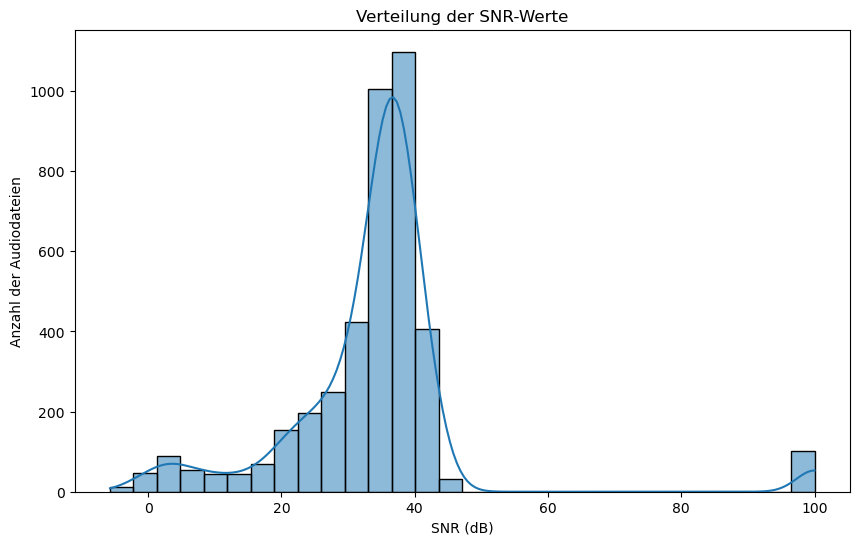

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Statistische Analyse der SNR-Werte
snr_stats = snr_df["snr"].describe()
print(snr_stats)

# Verteilung der SNR-Werte visualisieren
plt.figure(figsize=(10, 6))
sns.histplot(snr_df["snr"], bins=30, kde=True)
plt.xlabel("SNR (dB)")
plt.ylabel("Anzahl der Audiodateien")
plt.title("Verteilung der SNR-Werte")
plt.show()

In [17]:
import random

# Definiere Extrembereiche
low_snr_threshold = 0  # Alles unter 0 dB wird als stark verrauscht betrachtet
high_snr_threshold = 80  # Werte über 80 dB könnten problematisch sein

# Dateien mit extrem niedrigen SNR-Werten finden
low_snr_files = snr_df[snr_df["snr"] < low_snr_threshold]

# Dateien mit extrem hohen SNR-Werten finden
high_snr_files = snr_df[snr_df["snr"] > high_snr_threshold]

# Zufällige Auswahl von je 3 Beispielen aus beiden Kategorien
sample_low_snr = low_snr_files.sample(min(3, len(low_snr_files)))
sample_high_snr = high_snr_files.sample(min(3, len(high_snr_files)))

# Ergebnisse ausgeben
print("❌ Dateien mit sehr niedrigem SNR (< 0 dB):")
print(sample_low_snr)

print("\n✅ Dateien mit sehr hohem SNR (> 80 dB):")
print(sample_high_snr)

❌ Dateien mit sehr niedrigem SNR (< 0 dB):
                         filename       snr
168  common_voice_de_40206832.mp3 -1.591049
93   common_voice_de_40197049.mp3 -3.705840
141  common_voice_de_40203080.mp3 -0.490773

✅ Dateien mit sehr hohem SNR (> 80 dB):
                          filename    snr
2362  common_voice_de_40437713.mp3  100.0
836   common_voice_de_40232941.mp3  100.0
883   common_voice_de_40233008.mp3  100.0
